# Game of Sets - largest card deck with no matches

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle



## Function definitions
- make_card_names
- make_full_deck
- make_third_card

Functions to trim down from a full deck to a deck with no matches
- trim_deck_fast

Function to build up a deck with no matches
- make_deck_of_matches (a complementary deck)
- find_unused_cards

In [2]:
# make_card_names function initializes card_names df with names and attributes
def make_card_names():
    card_names = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    card_names['color'] = ['red', 'green', 'purple']
    card_names['shape'] = ['oval', 'diamond', 'squiggle']
    card_names['fill'] = ['solid', 'striped', 'empty']
    card_names['number'] = [1, 2, 3]
    return card_names

# make_full_deck function prepopulates complete card_deck df with all possible combinations using numbers 0, 1, 2 for each of four attributes (n=81)
def make_full_deck():
    card_deck = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    card_deck['color'] = [0] * 27 + [1] * 27 + [2] * 27
    card_deck['shape'] = ([0] * 9 + [1] * 9 + [2] * 9 ) * 3
    card_deck['fill'] =  ([0] * 3 + [1] * 3 + [2] * 3 ) * 9
    card_deck['number'] = [0, 1, 2] * 27
    return card_deck

# make_third_card function creates third card to make a set
def make_third_card(card1, card2):
    # Calculate the sum of corresponding elements in card1 and card2, then take the result mod 3
    sum_mod_3 = (card1.values[0] + card2.values[0]) % 3

    # Calculate the third integer 'c' based on the formula: c = 3 - (a + b) mod 3
    c_values = 3 - sum_mod_3
    c_values[c_values == 3] = 0  # Replace 3 with 0, as 3 mod 3 is 0

    # return the resulting dataframe card3
    return pd.DataFrame([c_values], columns=card1.columns)

In [3]:
# initialize a full card deck and confirm its length is 81 cards using make_full_deck function
card_deck = make_full_deck()
len(card_deck)

81

In [72]:
# find_unused_cards function with input of card_deck that finds unused cards
# return deck of all cards that match any pair in the input deck, and deck of cards not used
def find_unused_cards(card_deck, verbose=False):
    """
    This function finds unused cards in a given deck.

    Parameters:
    card_deck (pd.DataFrame): The input deck of cards. Each row represents a card.
    verbose (bool, optional): If True, the function prints lengths of decks. Default is False.

    Returns:
    match_deck (pd.DataFrame): A deck of all cards that match any pair in the input deck.
    unused_cards (pd.DataFrame): A deck of cards that are not used in either the input deck or the match deck.

    The function first checks for duplicate rows in the input deck. If any are found, it prints them out.
    It then creates a match deck, which is a deck of all cards that match any pair in the input deck.
    The function then combines the input deck and the match deck, checks for duplicates, and removes them if any are found.
    Finally, the function finds and returns the unused cards, which are the cards that are not in either the input deck or the match deck.
    If verbose is True, the function also prints out the lengths of the input deck, match deck, combined deck, and unused cards.
    """
    if card_deck.duplicated().any():
        print("Duplicate rows in trimmed_deck:")
        print(card_deck[card_deck.duplicated()])

    match_deck = make_deck_of_matches(card_deck).drop_duplicates()

    combined_deck = pd.concat([card_deck, match_deck]).reset_index(drop=True)
    if combined_deck.duplicated().any():
        print("Input card_deck has matches:")
        print(combined_deck[combined_deck.duplicated()])
        combined_deck.drop_duplicates(inplace=True)
        combined_deck.reset_index(drop=True, inplace=True)

    # find cards not used in card_deck or match_deck
    full_deck = make_full_deck()
    unused_cards = full_deck[~full_deck.apply(tuple, axis=1).isin(combined_deck.apply(tuple, axis=1))]

    if verbose:
        print("Length of input card_deck: ", len(card_deck))
        print("Length of match_deck: ", len(match_deck))
        print("Length of combined_deck: ", len(combined_deck))
        print("Length of unused_cards: ", len(unused_cards))
    return match_deck, unused_cards

In [6]:
# trim_deck_fast function selects two random cards, finds the third card that would make a set and drops it from the card_deck if it is present.
# Note that not all matching sets are necessarily removed. Search is random and not exhaustive.
def trim_deck_fast(card_deck, iterations=100):
    for i in range(iterations):
        card1 = card_deck.sample(n=1)
        card2 = card_deck.sample(n=1)
        # make sure card1 and card2 are not the same card
        while card1.equals(card2):
            card2 = card_deck.sample()
        card3 = make_third_card(card1, card2)
        # print('three cards {} {} {}'.format(card1, card2, card3))
        try: 
            i = card_deck[card_deck.eq(card3.squeeze()).all(1)].index
            # if i is not empty, remove the card from the deck
            if i.empty:
                pass
                # print('No set found. Continuing...')
            else:
                # print('Found a set! Removing cards {} {}'.format(i, card_deck.loc[i]))
                card_deck = card_deck.drop(i)
        except KeyError:
            pass
    return card_deck

In [ ]:
# test or run trim_deck_fast function
print(len(card_deck))
card_deck = trim_deck_fast(card_deck, iterations=1000)
len(card_deck)

In [22]:
test_deck = card_deck.iloc[[0, 4, 6, 10, 11, 20, 22, 34]]
print(test_deck)

#test_deck_of_matches = make_deck_of_matches(test_deck)

,color,shape,fill,number
0,0,0,0,0
4,0,0,1,1
6,0,0,2,0
10,0,1,0,1
11,0,1,0,2
20,0,2,0,2
22,0,2,1,1
34,1,0,2,1


In [23]:
# make_deck_of_matches function takes a card_deck and returns a deck of all cards that match any pair in the input deck

def make_deck_of_matches(card_deck):
    card_deck_of_matches = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    for i, (index1, _) in enumerate(card_deck.iterrows()):
        card1 = card_deck.loc[[index1]]
        for index2 in list(card_deck.index)[i+1:]:
            card2 = card_deck.loc[[index2]]
            card3 = make_third_card(card1, card2)
            # print(i, index1, card1, "\n")
            # print("index2 = ", index2, "\n card2 = ", card2, "\n")
            # print(card3)
            # card_deck_of_matches = card_deck_of_matches.append(card3) # this is slow
            card_deck_of_matches = pd.concat([card_deck_of_matches, card3], ignore_index=True)
    card_deck_of_matches.drop_duplicates(inplace=True)
    card_deck_of_matches.reset_index(drop=True, inplace=True)
    return card_deck_of_matches

## Legacy functions

In [8]:
# LEGACY is_set function takes in three cards and returns True if they are a set, False otherwise
def is_set(card1, card2, card3):
    # check if all cards are the same card
    if card1.equals(card2) and card2.equals(card3):
        return False
    # check if any two cards are the same card
    if card1.equals(card2) or card2.equals(card3) or card1.equals(card3):
        return False
    # check if any two cards are not a set
    if (card1['color'] + card2['color'] + card3['color']) % 3 != 0:
        return False
    if (card1['shape'] + card2['shape'] + card3['shape']) % 3 != 0:
        return False
    if (card1['fill'] + card2['fill'] + card3['fill']) % 3 != 0:
        return False
    if (card1['number'] + card2['number'] + card3['number']) % 3 != 0:
        return False
    # if all checks pass, return True
    return True

In [9]:
# LEGACY trim_sets function takes in a card deck and two cards selected by their index and returns a card deck with all cards making a set with those two cards removed
def trim_sets(card_deck, card1_index, card2_index):
    # check that card1_index and card2_index are in range
    if card1_index >= len(card_deck) or card2_index >= len(card_deck):
        print('Error: card index out of range')
        return card_deck
    # initialize empty list to store indices of sets
    sets = []
    # loop through all cards in deck
    for i in range(len(card_deck)):
        # check if cards are a set
        if is_set(card_deck.iloc[card1_index], card_deck.iloc[card2_index], card_deck.iloc[i]):
            # add index of set to sets list
            sets.append(i)
    # drop sets from card deck
    card_deck = card_deck.drop(sets)
    # reset index
    card_deck = card_deck.reset_index(drop=True)
    # return card deck
    return card_deck

In [271]:
# LEGACY trim_deck function takes in a card deck and uses the trim sets function to trim sets from the deck from a random starting point. Matching sets are *not* exhaustively removed.
# iterations defaults to 100, but can be changed to trim more sets
def trim_deck(card_deck, iterations=100):
    for i in range(iterations):
        # pick two random cards from the deck
        card1_index = np.random.randint(len(card_deck))
        card2_index = np.random.randint(len(card_deck))
        # trim card deck of all sets with those two cards
        card_deck = trim_sets(card_deck, card1_index, card2_index)
    return card_deck

## Cells to trim a full deck to a deck with no matches

1. First search for decks with no matches by trimming a full deck of 81 cards. 
1. Confirm that the trimmed deck doesn't contain any matches.
1. Write decks to csv files.

(array([7.000e+00, 8.700e+01, 3.510e+02, 1.035e+03, 2.127e+03, 2.987e+03,
        2.952e+03, 4.250e+02, 2.800e+01, 1.000e+00]),
 array([ 9. ,  9.9, 10.8, 11.7, 12.6, 13.5, 14.4, 15.3, 16.2, 17.1, 18. ]),
 <BarContainer object of 10 artists>)

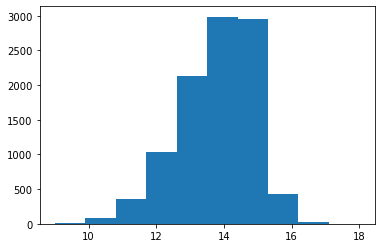

In [208]:
# trim a bunch of full card_decks and record the final lengths and resulting deck
trimmed_decks = []
trimmed_deck_lengths = []
for i in range(10000):
    # make a new deck
    card_deck = make_full_deck()
    # trim the deck
    card_deck = trim_deck_fast(card_deck, 200)
    # run again if length is more than 15, then 16
    if len(card_deck) > 15:
        card_deck = trim_deck_fast(card_deck, 1000)
    if len(card_deck) > 16:
        card_deck = trim_deck_fast(card_deck, 5000)
    # add the deck to the list of trimmed decks
    trimmed_decks.append(card_deck)
    # add the length of the deck to the list of trimmed deck lengths
    trimmed_deck_lengths.append(len(card_deck))

# plot the distribution of trimmed deck lengths
plt.hist(trimmed_deck_lengths)

In [ ]:
# count the number of times each deck length appears and sort the output
trimmed_deck_lengths = pd.Series(trimmed_deck_lengths)
trimmed_deck_lengths.value_counts().sort_index()


In [210]:
long_decks = []
for i in range(len(trimmed_decks)):
    if len(trimmed_decks[i]) > 16:
        long_decks.append(trimmed_decks[i])
len(long_decks)

29

In [ ]:
# loop through long_decks and apply trim_deck function to each deck
for i in range(len(long_decks)):
    long_decks[i] = trim_deck_fast(long_decks[i], 5000)

# print the length of each deck
for i in range(len(long_decks)):
    print(len(long_decks[i]))

In [214]:
# loop through long_decks and save each deck to a csv file
for i in range(len(long_decks)):
    long_decks[i].to_csv('trimmed_deck_b' + str(i) + '.csv', index=True)


In [ ]:
# print the decks from trimmed_decks with the longest length
for i in range(len(trimmed_decks)):
    if len(trimmed_decks[i]) > 16:
        print(i, trimmed_decks[i])

## Make larger decks from trimmed_deck starting places

Resulted in 13 decks with 18 cards each.

In [ ]:
# Import a saved trimmed deck
trimmed_deck = pd.read_csv('trimmed_deck964.csv', index_col=False)
trimmed_deck = trimmed_deck.reset_index(drop=True)
print("length = ", len(trimmed_deck))
print("duplicate rows: ", trimmed_deck[trimmed_deck.duplicated()])
trimmed_deck


In [46]:
match_deck, unused_cards = find_unused_cards(trimmed_deck)
unused_cards

Length of input card_deck:  17
Length of match_deck:  63
Length of combined_deck:  80
Length of unused_cards:  1


,color,shape,fill,number
23,0,2,1,2


In [47]:
bigger_deck = pd.concat([trimmed_deck, unused_cards]).reset_index(drop=True)
print("Length of bigger_deck: ", len(bigger_deck))
bigger_deck.head()

Length of bigger_deck:  18


,color,shape,fill,number
0,0,0,2,1
1,0,1,0,2
2,0,1,1,1
3,0,1,1,2
4,0,2,2,1


In [48]:
match_deck, unused_cards = find_unused_cards(bigger_deck)
unused_cards

Length of input card_deck:  18
Length of match_deck:  63
Length of combined_deck:  81
Length of unused_cards:  0


,color,shape,fill,number


In [ ]:
print(len(trimmed_decks), len(trimmed_deck_lengths))
print(trimmed_deck_lengths)

In [ ]:
# check each deck in trimmed_decks for duplicate rows
for i in range(len(trimmed_decks)):
    print(i, trimmed_decks[i][trimmed_decks[i].duplicated()])

In [56]:
# put decks with unused cards into unused_decks list
decks_to_grow = []
decks_to_growth_lengths = []
decks_to_grow_unused_cards_lengths = []

for i in range(len(trimmed_decks)):
    match_deck, unused_cards = find_unused_cards(trimmed_decks[i])
    if len(unused_cards) > 0:
        decks_to_grow.append(trimmed_decks[i])
        decks_to_growth_lengths.append(len(trimmed_decks[i]))
        decks_to_grow_unused_cards_lengths.append(len(unused_cards))
    
print(len(decks_to_grow), decks_to_growth_lengths, decks_to_grow_unused_cards_lengths)

13 [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17] [3, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1]


In [57]:
bigger_decks = decks_to_grow.copy()

In [64]:
# to each deck in bigger_decks, add one of the unused cards
for i in range(len(bigger_decks)):
    match_deck, unused_cards = find_unused_cards(bigger_decks[i])
    print(len(bigger_decks[i]), len(unused_cards))
    if len(unused_cards) > 0:
        bigger_decks[i] = pd.concat([bigger_decks[i], unused_cards.sample(n=1)]).reset_index(drop=True)
    
print(len(decks_to_grow))

18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
13


In [67]:
for i in range(len(bigger_decks)):
    print(len(bigger_decks[i]))

18
18
18
18
18
18
18
18
18
18
18
18
18


## Saving and loading decks to files

In [112]:
# save decks to csv files
decks_length_18plus[0].to_csv('deck_length_20.csv', index=False)

In [49]:
# import csv files into trimmed_decks list LEGACY
import glob

trimmed_decks = []
trimmed_deck_lengths = []

# Get a list of all CSV files in the current directory that start with 'trimmed_deck_'
csv_files = glob.glob('trimmed_deck_*.csv')

# Loop through the list of CSV files
for file in csv_files:
    # Read the CSV file into a DataFrame
    trimmed_deck = pd.read_csv(file, usecols=['color', 'shape', 'fill', 'number'])
    trimmed_deck = trimmed_deck.reset_index(drop=True)
    
    # Append the DataFrame to the list
    trimmed_decks.append(trimmed_deck)
    
    # Append the length of the DataFrame to the list
    trimmed_deck_lengths.append(len(trimmed_deck))

In [138]:
# save deck_length_18plus list as a pickle file

# Create a dictionary to hold the DataFrames
decks_length_20_dict = {f'deck_{i}': df for i, df in enumerate(decks_length_18plus)}

# Save the dictionary as a pickle file
with open('decks_length_20c_dict.pkl', 'wb') as f:
    pickle.dump(decks_length_20_dict, f)

In [ ]:
# Load the dictionary from the pickle file
with open('decks_length_20_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

# Now you can access the DataFrames from the dictionary
first_deck_df = loaded_dict['deck_0']

In [ ]:
# save unused_cards_lengths_sequences list as a csv file
with open('unused_cards_lengths_sequences.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(unused_cards_lengths_sequences)

## Build up decks from scratch using random selection processes

Results from 3 runs of 10,000 iterations each
- 30% decks of 18 cards (3042, 2963, and 3040/10,000)
- 0.15% decks of 20 cards (22, 12, and 7/10,000)
- no decks of 19 cards

Conjecture: maximal decks must have an even number of cards.\
  reasoning: all cards not in the deck ("matching cards") are associated with pairs of cards in the deck.\
  check to see if there are maximal decks with 17 or fewer cards

In [134]:
verbose = False

unused_cards_lengths_sequences = []
decks_length_18 = []
decks_length_18plus = []

for i in range(10000):
    full_deck = make_full_deck()
    card_deck = full_deck.sample(n=2)
    match_deck, unused_cards = find_unused_cards(card_deck)
    unused_cards_lengths = [81, 78]

    while len(unused_cards) > 0:
        card_deck = pd.concat([card_deck, unused_cards.sample(n=1)]).reset_index(drop=True)
        match_deck, unused_cards = find_unused_cards(card_deck)
        unused_cards_lengths.append(len(unused_cards))
        if verbose:
            print(len(card_deck), len(match_deck), len(unused_cards))

    unused_cards_lengths_sequences.append(unused_cards_lengths)

    if len(card_deck) == 18:
        decks_length_18.append(card_deck)
    elif len(card_deck) > 18:
        decks_length_18plus.append(card_deck)
        if len(card_deck) > 20:
            card_deck.to_csv('deck_length_20plus.csv', index=False)

    if verbose:
        print("Length of card_deck: ", len(card_deck))
        print("Length of match_deck: ", len(match_deck))
        print("Length of unused_cards: ", len(unused_cards))
        print("Lengths of unused_cards: ", len(unused_cards_lengths))

print("Number of unused_cards sequences", len(unused_cards_lengths_sequences))
print("Number of decks_length_18", len(decks_length_18))
print("Number of decks_length_18plus", len(decks_length_18plus))


Number of unused_cards sequences 10000
Number of decks_length_18 3040
Number of decks_length_18plus 7


In [ ]:
for i in range(50):
    print(len(unused_cards_lengths_sequences[3:200][i]))

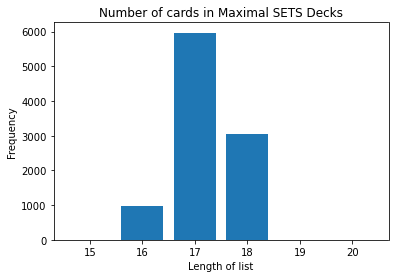

[0, 984, 5969, 3040, 0, 7]

In [154]:
import matplotlib.pyplot as plt

# create a list of lengths of the lists in unused_cards_lengths_sequences
lengths = [len(lst) for lst in unused_cards_lengths_sequences]

# create a bar chart of the lengths
plt.bar(range(15, 21), [lengths.count(i) for i in range(15, 21)])
plt.xlabel('Length of list')
plt.ylabel('Frequency')
plt.title('Number of cards in Maximal SETS Decks')
plt.xticks(range(15, 21))
plt.show()

[lengths.count(i) for i in range(15, 21)]


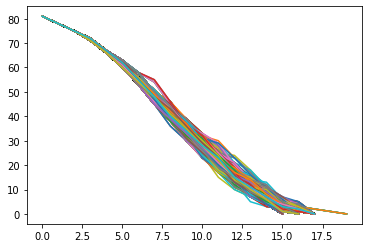

In [135]:
# graph unused_cards_lengths_sequences
for i in range(len(unused_cards_lengths_sequences)):
    plt.plot(unused_cards_lengths_sequences[i])

In [ ]:
for i in range(len(decks_length_18plus)):
    print(i, len(decks_length_18plus[i]))
    decks_length_18plus[i].to_csv('deck_length_20_c' + str(i) + '.csv', index=False)


In [164]:
decks_length_18plus[2].sort_values(by=['color', 'shape', 'fill', 'number']).reset_index(drop=True)


,color,shape,fill,number
0,0,0,0,2
1,0,0,2,1
2,0,1,0,0
3,0,1,1,2
4,0,1,2,0
5,0,1,2,2
6,0,2,1,0
7,0,2,2,1
8,1,0,0,1
9,1,0,2,0
